# Butterflies

This is a prototype implementation of how to compute butterflies for spectral models.
It should be integrated properly (including tests & docs) in gammapy.spectrum.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import uncertainties
from uncertainties import unumpy
from astropy import units as u
from astropy.table import Table
from gammapy.utils.energy import Energy

In [2]:
table = Table.read('https://github.com/gammapy/gammapy-extra/raw/master/datasets/catalogs/fermi/gll_psch_v08.fit.gz')

In [3]:
def get_2fhl_source(name):
    idx = np.where(table['Source_Name'] == name)[0]
    return table[idx][0]

source = get_2fhl_source('2FHL J0617.2+2234e')

In [4]:
class PowerLawSpectrum:
    
    def __init__(self, flux, flux_err, gamma, gamma_err, energy_pivot=0.1):
        self.flux = flux
        self.flux_err = flux_err
        self.gamma = gamma
        self.gamma_err = gamma_err
        self.energy_pivot = energy_pivot

    @classmethod
    def from_dict(cls, source):
        energy0 = 0.1
        energy1, energy2 = 0.05, 2
        gamma = source['Spectral_Index']
        gamma_err = source['Unc_Spectral_Index']
        term1 = (gamma - 1) / energy0
        term2 = (energy1 / energy0) ** (1 - gamma)
        term3 = (energy2 / energy0) ** (1 - gamma)
        int_flux_to_diff_flux = term1 / (term2 - term3)
        flux = source['Flux50'] * int_flux_to_diff_flux
        flux_err = source['Unc_Flux50'] * int_flux_to_diff_flux
        return cls(flux=flux, flux_err=flux_err,
                  gamma=gamma, gamma_err=gamma_err,
                  energy_pivot=energy0)
        
    @staticmethod
    def evaluate(energy, flux, gamma, energy_pivot, use_sed=False):
        val = flux * (energy / energy_pivot) ** (-gamma)
        
        if use_sed:
            val *= 1.6 * (energy ** 2)
        
        return val
    
    def butterfly(self, energy):
        source_flux = unumpy.uarray(self.flux, self.flux_err)
        gamma = unumpy.uarray(self.gamma, self.gamma_err)
        flux = PowerLawSpectrum.evaluate(energy, source_flux, gamma, self.energy_pivot, use_sed=True)
#         print(type(flux))
        val = np.array([_.nominal_value for _ in flux])
        err = np.array([_.std_dev for _ in flux])
        
        flux_mid = val
        flux_hi = val + err
        flux_lo = val - err
        return dict(energy=energy, flux_lo=flux_lo, flux=flux_mid, flux_hi=flux_hi)

In [5]:
spec = PowerLawSpectrum.from_dict(source)
energy = Energy.equal_log_spacing(50 * u.GeV, 2 * u.TeV, 30).value
bf = spec.butterfly(energy)

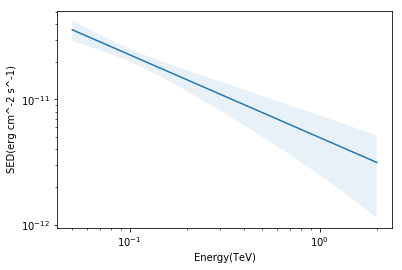

In [24]:
def plot_butterfly(data):
    plt.plot(data['energy'], data['flux'])
    plt.fill_between(data['energy'], data['flux_lo'], data['flux_hi'],
                    alpha=0.1, linewidth=0)

    plt.loglog()
    plt.xlabel('Energy(TeV)')
    plt.ylabel('SED(erg cm^-2 s^-1)')

plot_butterfly(bf)